# Imports

In [26]:
from __future__ import annotations

from PIL import Image

from IPython.display import clear_output

import sklearn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pytorch with gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# Load Classification Data

,X1,X2,label
0,1.007838,-0.132248,0
1,0.076208,-1.014829,0
2,-0.193797,-0.880081,1
3,-0.452996,-0.786208,1
4,0.245603,0.872104,1


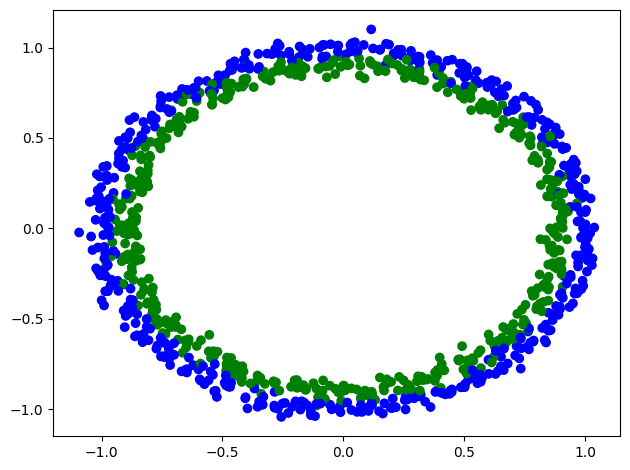

In [27]:
from sklearn.datasets import make_circles

# create 1000 circles
n_samples = 1000
X_, y_ = make_circles(n_samples=n_samples, 
                    noise=0.03,
                    factor=0.9, 
                    random_state=21)
plt.scatter(X_[:, 0], X_[:, 1], c=['g' if v == 1 else 'b' for v in y_])
plt.tight_layout()

circles = pd.DataFrame({'X1': X_[:, 0],
                        'X2': X_[:, 1],
                        'label': y_})
circles.head()

# Tensorification and Splitting

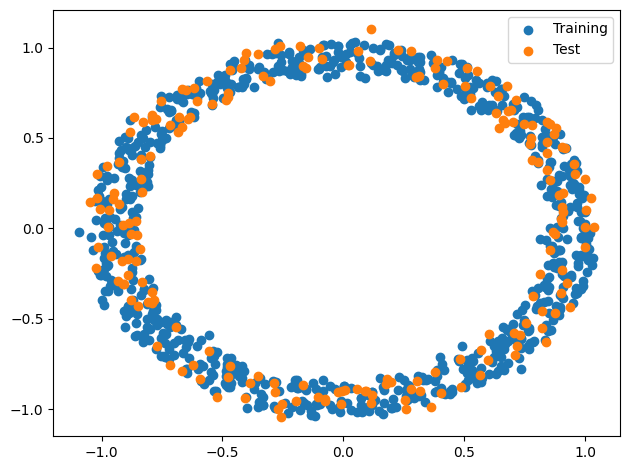

In [28]:
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X_).type(torch.float).to('cuda')
y = torch.from_numpy(y_).type(torch.float).to('cuda')

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), label='Training')
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), label='Test')
plt.legend()
plt.tight_layout()

# Model Building

In [29]:
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.optim = None
        self.loss_fn = None
        self.history = {'accuracy': [], 'loss': []}

        # create 2 nn.Linear layers to handle input and output of data and predictions
        # this creates a neural network with one hidden layer with 8 neurons
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)

    # define forward() method that outlines the forward pass
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X -> layer 1 -> layer 2 -> output
        return self.layer_2(torch.sigmoid(self.layer_1(X)))
    
    def compile(self, optim: torch.optim.Optimizer, loss_fn: torch.nn.modules.loss._Loss) -> None:
        self.optim = optim
        self.loss_fn = loss_fn
    
    def fit(self, X: torch.Tensor, y: torch.Tensor, epochs: int) -> None:
        self.train(True)

        for epoch in range(epochs):
            # get predictions
            y_pred_logits = self(X).squeeze()
            y_pred = torch.round(torch.sigmoid(y_pred_logits))
            
            # calculate loss
            loss = self.loss_fn(y_pred_logits, y)

            # backpropagation and gradient descent
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

            self.history['loss'].append(loss.item())
            accuracy = (torch.eq(y_pred, y.squeeze()).sum().item() / len(y.squeeze())) * 100
            self.history['accuracy'].append(accuracy)
            
    def predict(self, X: torch.Tensor) -> torch.Tensor:
        self.eval()

        with torch.inference_mode():
            return torch.round(torch.sigmoid(self(X).squeeze())).cpu().detach()

            

cuda:0


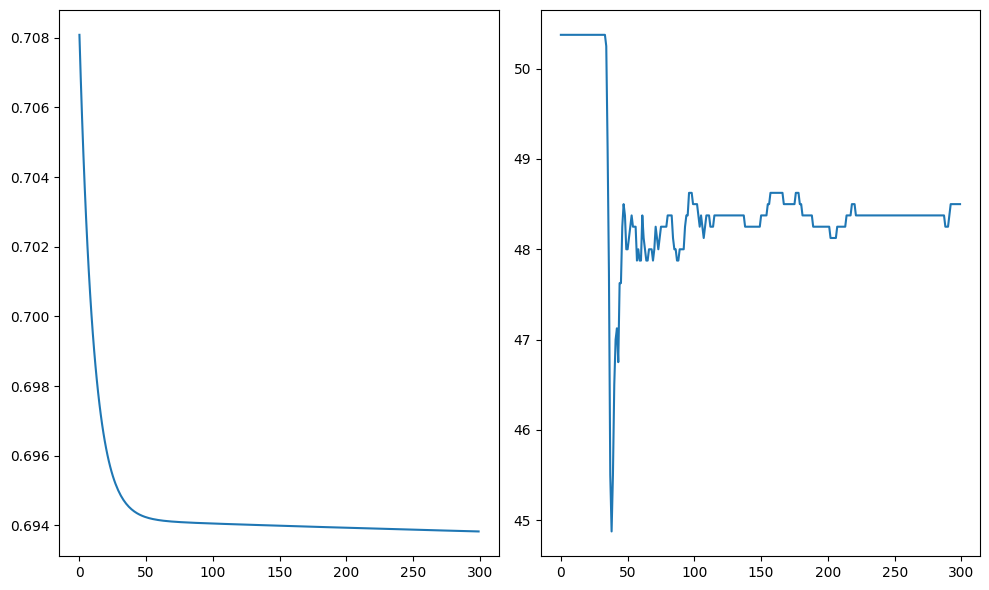

In [30]:
# create model and send to device (gpu)
model_0 = CircleModelV0().to('cuda')
print(next(model_0.parameters()).device)

# train model
model_0.compile(optim=torch.optim.SGD(model_0.parameters(), lr=0.06), loss_fn=nn.BCEWithLogitsLoss())
model_0.fit(X_train, y_train, epochs=300)

# plot results
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(model_0.history['loss'])
plt.subplot(122)
plt.plot(model_0.history['accuracy'])
plt.tight_layout()

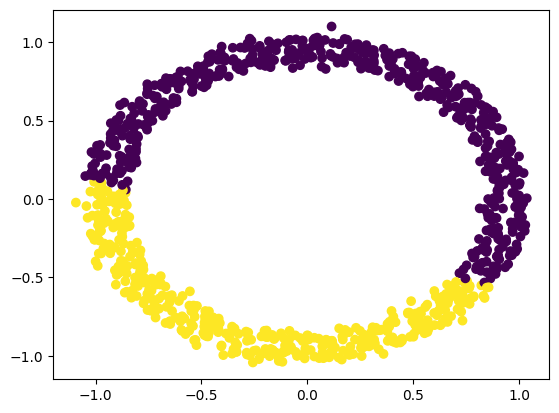

In [31]:
hue = model_0.predict(X_test)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=hue)

hue = model_0.predict(X_train)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=hue)

# Model 2 
- A completely linear model will never be able to classify the 2 classes 
- Introduce ReLU into the `model.forward()` method to introduce non-linearity
- Increase the epochs and adjust learning rate

| Epoch: 000 | Loss: 0.696, Acc: 49.625 | Test Loss: 0.693, Test Acc: 51.500 | Best Acc: 49.625
| Epoch: 050 | Loss: 0.693, Acc: 52.875 | Test Loss: 0.692, Test Acc: 57.500 | Best Acc: 52.875
| Epoch: 100 | Loss: 0.693, Acc: 50.250 | Test Loss: 0.692, Test Acc: 50.500 | Best Acc: 62.500
| Epoch: 150 | Loss: 0.692, Acc: 52.250 | Test Loss: 0.692, Test Acc: 49.000 | Best Acc: 62.500
| Epoch: 200 | Loss: 0.692, Acc: 52.000 | Test Loss: 0.692, Test Acc: 49.500 | Best Acc: 62.500
| Epoch: 250 | Loss: 0.692, Acc: 52.000 | Test Loss: 0.692, Test Acc: 50.000 | Best Acc: 62.500
| Epoch: 300 | Loss: 0.692, Acc: 53.375 | Test Loss: 0.692, Test Acc: 51.000 | Best Acc: 62.500
| Epoch: 350 | Loss: 0.692, Acc: 52.875 | Test Loss: 0.692, Test Acc: 49.500 | Best Acc: 62.500
| Epoch: 400 | Loss: 0.692, Acc: 53.375 | Test Loss: 0.693, Test Acc: 49.000 | Best Acc: 62.500
| Epoch: 450 | Loss: 0.692, Acc: 54.375 | Test Loss: 0.693, Test Acc: 46.000 | Best Acc: 62.500
| Epoch: 500 | Loss: 0.691, Acc: 55.250 

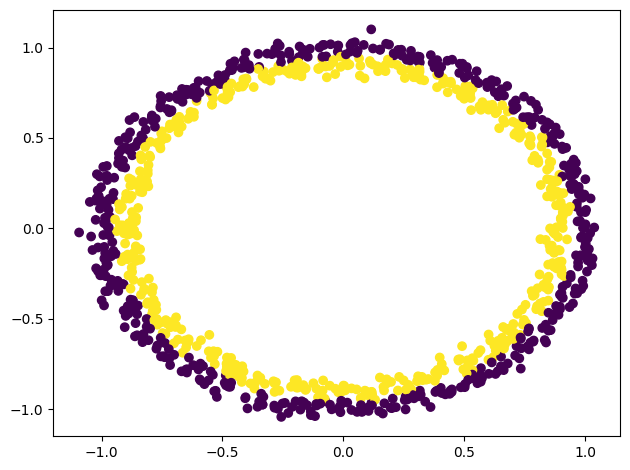

In [45]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=16)
        self.layer_4 = nn.Linear(in_features=16, out_features=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        z = self.layer_1(X)
        z = torch.relu(z)
        z = self.layer_2(z)
        z = torch.relu(z)
        z = self.layer_3(z)
        z = torch.relu(z)
        z = self.layer_4(z)
        
        return z
    
# define model and related
model_1 = CircleModelV1().to('cuda:0')
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(model_1.parameters(), lr=0.1)

# training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 5000
acc_highscore = 0

# put data on target device
X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
X_test, y_test = X_test.to('cuda'), y_test.to('cuda')

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train) 
    acc = (torch.eq(y_pred, y_train).sum().item() / len(y_train)) * 100

    if acc > acc_highscore:
        acc_highscore = acc

    optim.zero_grad()
    loss.backward()
    optim.step()

    # test every 100 epochs
    if epoch % 50 == 0:
        model_1.eval()
        with torch.inference_mode():
            test_logits = model_1(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            test_acc = (torch.eq(test_pred, y_test).sum().item() / len(y_test)) * 100

            print(f'| Epoch: {epoch:0>3} | Loss: {loss:.3f}, Acc: {acc:.3f} | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f} | Best Acc: {acc_highscore:.3f}')

y_logits = model_1(X_test).squeeze()
y_pred = torch.round(torch.sigmoid(y_logits)).cpu().detach()
plt.scatter(X_test[:,0].cpu(), X_test[:,1].cpu(), c=y_pred)
y_logits = model_1(X_train).squeeze()
y_pred = torch.round(torch.sigmoid(y_logits)).cpu().detach()
plt.scatter(X_train[:,0].cpu(), X_train[:,1].cpu(), c=y_pred)
plt.tight_layout()

# Another Dataset

In [215]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=5, n_classes=3, n_informative=3, random_state=42)
X = torch.from_numpy(X).type(torch.float).to('cuda')
y = torch.from_numpy(y).type(torch.float).to('cuda')
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [217]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=5, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=5)
        self.layer_3 = nn.Linear(in_features=5, out_features=5)
        self.layer_4 = nn.Linear(in_features=5, out_features=5)
        self.layer_5 = nn.Linear(in_features=5, out_features=3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        z = self.layer_1(X)
        z = torch.relu(z)
        z = self.layer_2(z)
        z = torch.relu(z)
        z = self.layer_3(z)
        z = torch.relu(z)
        z = self.layer_4(z)
        z = torch.relu(z)
        z = self.layer_5(z)
        
        return z
    
# define model and related
model_1 = CircleModelV1().to('cuda:0')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adamax(model_1.parameters(), lr=0.03)

# training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 5000
acc_highscore = 0

# put data on target device
X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
X_test, y_test = X_test.to('cuda'), y_test.to('cuda')

for epoch in range(epochs):
    model_1.train()

    y_pred = torch.softmax(model_1(X_train), 1)

    loss = loss_fn(y_pred, y_train)
    acc = torch.sum(torch.argmax(y_pred) == y_train) / len(y_train) * 100

    if acc > acc_highscore:
        acc_highscore = acc

    optim.zero_grad()
    loss.backward()
    optim.step()

    # test every few epochs
    if epoch % 50 == 0:
        model_1.eval()
        with torch.inference_mode():
            test_pred = torch.softmax(model_1(X_test), 1)

            test_loss = loss_fn(test_pred, y_test)
            test_acc = torch.sum(torch.argmax(test_pred, 1) == y_test) / len(y_train) * 100

            print(f'| Epoch: {epoch:0>4} | Loss: {loss:.3f}, Acc: {acc:.3f} | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f} | Best Acc: {acc_highscore:.3f}')

RuntimeError: "host_softmax" not implemented for 'Long'

Model is outperformed by a simple decision tree classifier, the DTC is just more well suited to the classification problem than the neural network